# Udacity Capstone Projcet - Dogs vs Cats

## 环境配置

在运行程序之前，需要确保本地conda环境与与environment.yml中提供的环境内容是相同或者可以替代的。

同时也需要注意硬件的使用以及对应驱动的安装。本次运行使用的平台以及对应驱动是CUDA 10.2，Nvidia-SMI: 430.26。
这一步需要根据计算机系统以及硬件进行相应的安装，因此在这里不作过多的叙述。

In [17]:
## Denpendencies
import os
import csv
import cv2
import h5py
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm  
from time import time
from PIL import Image
from functions_collection import *

## Keras
from keras.applications.xception import decode_predictions
from keras.applications.xception import preprocess_input
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing import image
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from keras import backend as K

## GPU choice
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Specific setting for CUDNN_STATUS_INTERNAL_ERROR
#config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=0.95))
sess = tf.Session(config=config)

## 数据探索以及可视化

首先，我们需要了解Kaggle提供的训练集和测试集的数据量。我们可以发现在训练集的图像中有对应的cat和dog的标记，根据这个文件命名的规则，我们可以通过统计具有相应命名规律的图像数目。

In [2]:
!echo "cat figures: $(find train/ -name 'cat*jpg' | wc -l)"
!echo "dog figures: $(find train/ -name 'dog*jpg' | wc -l)"
!echo "test figures: $(find test/ -name '*.jpg' | wc -l)"

cat figures: 12500
dog figures: 12500
test figures: 12500


我们可以发现，Kaggle的训练集数据中有12500张猫的照片，12500张狗的照片，并在测试集中提供了没有标记的12500张测试图片。

同时，由于在训练的过程中我们需要统一图像的尺寸，我们在进行训练之前，可以对训练集中的图像尺寸特征先进行一定的探索。

In [3]:
## read images
train_filenames = os.listdir('train')
train_cat = [img for img in filter(lambda x:x[:3] == 'cat', train_filenames)]
train_dog = [img for img in filter(lambda x:x[:3] == 'dog', train_filenames)]


train_all = np.concatenate((train_cat,train_dog))

type(train_all)


## genreate the shapes data from train_all
shapes = get_shape(train_all)

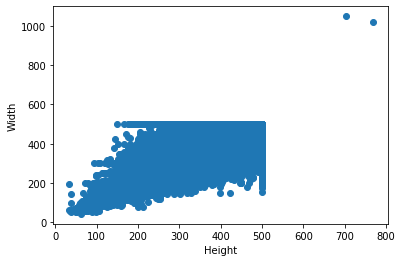

In [4]:
# Scatter
height = [i[0] for i in shapes]
width = [i[1] for i in shapes]

plt.scatter(height, width)
plt.xlabel('Height')
plt.ylabel('Width')
plt.show()

从上图我们可以发现,Kaggle提供的图像大小并非完全相同的，因此我们在后续对图像的尺寸进行规范。

## 数据预处理

通过上述的数据探索，我们大致了解了数据量以及图像的尺寸。首先我们需要将训练集中猫和狗的图像分别放入对应类型的文件夹中，而这个过程主要是通过创建图像的符号链接(symbol link)实现的。

In [2]:
train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

set_mkdir('trainAlter')
os.mkdir('trainAlter/cat')
os.mkdir('trainAlter/dog')

set_mkdir('testAlter')
os.symlink('../test/', 'testAlter/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'trainAlter/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'trainAlter/dog/'+filename)

In [3]:
## Generate symbol-link
train_data_dir, valid_data_dir, test_data_dir = symbol_link()

100%|██████████| 12500/12500 [00:00<00:00, 66873.13it/s]


In [4]:
write_data(Xception, (299, 299), batch_size=16, dir_train="trainAlter", dir_test="testAlter", lambda_func=xception.preprocess_input)







Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 139s 178ms/step


In [4]:
X_train, Y_train, X_test = export_data("data_xception.h5")

经过上述处理之后，目前的文件目录如文件tree.txt所示。通过生成symbol link，我们可以通过data_xception.h5对训练集中的两种图像分别生成不同目录下的索引，同时统一索引了测试集中的图像。在生成data_xception.h5的同时，我们通过ImageDataGenerator对图像数据进行了数据增强，从而使得使用这些数据进行训练的模型可以具有更好的适应性，防止模型过拟合并提高泛化能力.。

## 迁移学习模型构建

基于在报告中提到的理由，我们将使用Xception作为我们迁移学习的基础。关于Xception的资料可以参考report中提供的参考文献，而在Keras和Tensorlfow中也为使用预先训练的Xception模型也提供了较好的支持。

我们首先需要对Xception在图像分类上的基本能力进行检测，尝试将对Xception模型进行初步的测试以及Kaggle的检验。

In [6]:
## Construct the model
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
## Training
filepath="xception-tune0-best_weight.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
         callbacks=callbacks_list)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 66us/step - loss: 0.3030 - acc: 0.9323 - val_loss: 0.1263 - val_acc: 0.9912
Epoch 2/20
20000/20000 [==============================] - 0s 20us/step - loss: 0.0957 - acc: 0.9873 - val_loss: 0.0580 - val_acc: 0.9944
Epoch 3/20
20000/20000 [==============================] - 0s 20us/step - loss: 0.0558 - acc: 0.9893 - val_loss: 0.0372 - val_acc: 0.9946
Epoch 4/20
20000/20000 [==============================] - 0s 19us/step - loss: 0.0418 - acc: 0.9906 - val_loss: 0.0289 - val_acc: 0.9952
Epoch 5/20
20000/20000 [==============================] - 0s 18us/step - loss: 0.0360 - acc: 0.9909 - val_loss: 0.0249 - val_acc: 0.9952
Epoch 6/20
20000/20000 [==============================] - 0s 19us/step - loss: 0.0318 - acc: 0.9918 - val_loss: 0.0225 - val_acc: 0.9948
Epoch 7/20


In [11]:
## Testing
predict_on_model(test_data_dir, X_test, model, "pred-xception-original.csv")

12500/12500 [==============================] - 0s 28us/step
Found 12500 images belonging to 1 classes.


将pred-xceptio-original.csv提交到Kaggle中进行评分，Xception-original本次的得分为:0.04180

具体的得分情况可以在报告文档中进行查看。

## Dropout Rate 调整

为了对模型参数进行后续的优化，我们可以通过调整Dropout Rate对模型参数进行调优并且减少模型的过拟合情况，使算法在一个更大的权值空间中搜索更好的权值，而不用担心权值过大。

因此我们将在这里对Dropout Rate进行调整，并找出相对适合Xception模型的Dropout值。

In [12]:
epochs = 20

dropout_info = []
dropout_result=[]
pd_data = []
dropout_list = np.arange(0.1,1,0.1)
for dropout in dropout_list:
    rate_data=dropout_tuning(round(dropout,1), X_train, Y_train, epochs)
    dropout_result.append(rate_data)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 31us/step - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0122 - val_acc: 0.9952
Epoch 2/20
20000/20000 [==============================] - 0s 15us/step - loss: 0.0148 - acc: 0.9953 - val_loss: 0.0120 - val_acc: 0.9954
Epoch 3/20
20000/20000 [==============================] - 0s 18us/step - loss: 0.0144 - acc: 0.9954 - val_loss: 0.0120 - val_acc: 0.9958
Epoch 4/20
20000/20000 [==============================] - 0s 18us/step - loss: 0.0145 - acc: 0.9954 - val_loss: 0.0120 - val_acc: 0.9956
Epoch 5/20
20000/20000 [==============================] - 0s 17us/step - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0120 - val_acc: 0.9954
Epoch 6/20
20000/20000 [==============================] - 0s 16us/step - loss: 0.0141 - acc: 0.9957 - val_loss: 0.0119 - val_acc: 0.9954
Epoch 7/20
20000/20000 [==============================] - 0s 19us/step - loss: 0.0143 - acc: 0.9951 - val_loss: 0.0119 - val_acc:

20000/20000 [==============================] - 0s 17us/step - loss: 0.0194 - acc: 0.9937 - val_loss: 0.0118 - val_acc: 0.9954
Epoch 17/20
20000/20000 [==============================] - 0s 16us/step - loss: 0.0187 - acc: 0.9938 - val_loss: 0.0118 - val_acc: 0.9954
Epoch 18/20
20000/20000 [==============================] - 0s 15us/step - loss: 0.0184 - acc: 0.9942 - val_loss: 0.0118 - val_acc: 0.9956
Epoch 19/20
20000/20000 [==============================] - 0s 19us/step - loss: 0.0194 - acc: 0.9934 - val_loss: 0.0118 - val_acc: 0.9956
Epoch 20/20
20000/20000 [==============================] - 0s 20us/step - loss: 0.0198 - acc: 0.9936 - val_loss: 0.0118 - val_acc: 0.9956
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 36us/step - loss: 0.0226 - acc: 0.9927 - val_loss: 0.0121 - val_acc: 0.9956
Epoch 2/20
20000/20000 [==============================] - 0s 19us/step - loss: 0.0222 - acc: 0.9936 - val_loss: 0.0121 - val_acc: 0.9956

In [13]:
## dropout rate and val_loss
for index in range(len(dropout_result)):
    row = []
    avg_value = np.average(dropout_result[index][1])
    max_value = np.max(dropout_result[index][1])
    min_value = np.min(dropout_result[index][1])
    dropout_value = dropout_list[index]
    row.append(dropout_value)
    row.append(avg_value)
    row.append(max_value)
    row.append(min_value)
    pd_data.append(row)

val_loss_df = pd.DataFrame(
    data=pd_data,
    columns=['Dropout', 'Avg', 'Max', 'Min']
)

val_loss_df

,Dropout,Avg,Max,Min
0,0.1,0.011932,0.012197,0.011845
1,0.2,0.011889,0.012069,0.011770
2,0.3,0.011922,0.012120,0.011806
3,0.4,0.011952,0.012200,0.011790
4,0.5,0.011956,0.012080,0.011854
5,0.6,0.011907,0.012183,0.011750
6,0.7,0.012001,0.012144,0.011861
7,0.8,0.012288,0.012565,0.012081
8,0.9,0.013365,0.013602,0.013175


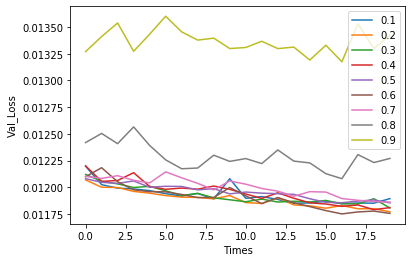

In [14]:
## visualization the result
for index in range(len(dropout_result)):
    plt.plot(dropout_result[index][1],label=dropout_result[index][0])

plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.legend(loc='best')
plt.show()

从DataFrame以及可视化的结果中可以看出，Dropout Rate等于0.2的时候结果平均值和最大值是最佳的，而其最小值也是倒数第二小的。因此可以认为Dropout值为0.2时效果最佳。

然后我将对一些其中表现及较好的其他的Dropout数值（0.2, 0.4, 0.6）进行训练：

In [28]:
## Construct the model
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
## Training
filepath="xception-tune0-best_weight.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
         callbacks=callbacks_list)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 113us/step - loss: 0.2505 - acc: 0.9678 - val_loss: 0.1073 - val_acc: 0.9936
Epoch 2/20
20000/20000 [==============================] - 0s 22us/step - loss: 0.0793 - acc: 0.9896 - val_loss: 0.0501 - val_acc: 0.9948
Epoch 3/20
20000/20000 [==============================] - 0s 22us/step - loss: 0.0465 - acc: 0.9907 - val_loss: 0.0326 - val_acc: 0.9950
Epoch 4/20
20000/20000 [==============================] - 1s 26us/step - loss: 0.0352 - acc: 0.9919 - val_loss: 0.0257 - val_acc: 0.9952
Epoch 5/20
20000/20000 [==============================] - 0s 25us/step - loss: 0.0300 - acc: 0.9923 - val_loss: 0.0222 - val_acc: 0.9950
Epoch 6/20
20000/20000 [==============================] - 0s 25us/step - loss: 0.0277 - acc: 0.9924 - val_loss: 0.0204 - val_acc: 0.9950
Epoch 7/20
20000/20000 [==============================] - 0s 25us/step - loss: 0.0259 - acc: 0.9927 - val_loss: 0.0191 - val_acc

In [30]:
## Testing
predict_on_model(test_data_dir, X_test, model, "pred-xception-dropout.csv")

12500/12500 [==============================] - 1s 74us/step
Found 12500 images belonging to 1 classes.


将使用了不同的Dropout值的pred-xception-dropout.csv提交到Kaggle中进行评分，

- Dropout Rate = 0.2的得分为:0.04057。
- Dropout Rate = 0.4的得分为:0.04145。
- Dropout Rate = 0.5的得分为:0.04180，这个是由前面的pred-xception-original.csv得到的。
- Dropout Rate = 0.6的得分为:0.04196。

可以看出在对Dropout率进行调整之后，结果是有所提高的，我们取其中最优秀的评分，即Dropout Rate = 0.2进行后续的训练。

具体的得分情况可以在报告文档中进行查看。

## 训练不同层级的参数与权重

我们对于Xception不同层的权重训练将从使用Dropout Rate=0.2的Xception模型开始。首先，我们将使用在Udacity深度学习模块中的策略，先冻结所有Xception的权重参数并对其全连接层进行训练。

In [34]:
#构造模型
x_input = Input((299, 299, 3))
x_input = Lambda(xception.preprocess_input)(x_input)

base_model = Xception(input_tensor=x_input, weights='imagenet', include_top=False, pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False
    
x = Dropout(0.2)(base_model.output)
x = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(x)
model = Model(base_model.input, x)
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

gen = ImageDataGenerator(rotation_range=90,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

val_gen = ImageDataGenerator()

train_generator = gen.flow_from_directory(train_data_dir, (299, 299), shuffle=True, 
                                          batch_size=32,class_mode='binary')
valid_generator = val_gen.flow_from_directory(valid_data_dir, (299, 299), shuffle=True, 
                                          batch_size=32,class_mode='binary')

for i in range(len(model.layers)):
    print(i,model.layers[i].name)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
0 input_8
1 lambda_6
2 block1_conv1
3 block1_conv1_bn
4 block1_conv1_act
5 block1_conv2
6 block1_conv2_bn
7 block1_conv2_act
8 block2_sepconv1
9 block2_sepconv1_bn
10 block2_sepconv2_act
11 block2_sepconv2
12 block2_sepconv2_bn
13 conv2d_21
14 block2_pool
15 batch_normalization_21
16 add_61
17 block3_sepconv1_act
18 block3_sepconv1
19 block3_sepconv1_bn
20 block3_sepconv2_act
21 block3_sepconv2
22 block3_sepconv2_bn
23 conv2d_22
24 block3_pool
25 batch_normalization_22
26 add_62
27 block4_sepconv1_act
28 block4_sepconv1
29 block4_sepconv1_bn
30 block4_sepconv2_act
31 block4_sepconv2
32 block4_sepconv2_bn
33 conv2d_23
34 block4_pool
35 batch_normalization_23
36 add_63
37 block5_sepconv1_act
38 block5_sepconv1
39 block5_sepconv1_bn
40 block5_sepconv2_act
41 block5_sepconv2
42 block5_sepconv2_bn
43 block5_sepconv3_act
44 block5_sepconv3
45 block5_sepconv3_bn
46 add_64
47 block6_sepconv1_act
48 block6_sepc

In [35]:
filepath="xception-best_weight_freeze.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

recordFreeze = model.fit_generator(
        train_generator,
        steps_per_epoch=625,
        epochs=15,
        validation_data=valid_generator,
        validation_steps=150,
        callbacks = callbacks_list)

Epoch 1/15
625/625 [==============================] - 286s 457ms/step - loss: 0.2768 - acc: 0.9155 - val_loss: 0.0991 - val_acc: 0.9870
Epoch 2/15
625/625 [==============================] - 267s 427ms/step - loss: 0.1694 - acc: 0.9413 - val_loss: 0.0724 - val_acc: 0.9872
Epoch 3/15
625/625 [==============================] - 267s 427ms/step - loss: 0.1537 - acc: 0.9470 - val_loss: 0.0645 - val_acc: 0.9872
Epoch 4/15
625/625 [==============================] - 267s 427ms/step - loss: 0.1499 - acc: 0.9453 - val_loss: 0.0627 - val_acc: 0.9892
Epoch 5/15
625/625 [==============================] - 270s 432ms/step - loss: 0.1456 - acc: 0.9473 - val_loss: 0.0591 - val_acc: 0.9886
Epoch 6/15
625/625 [==============================] - 272s 435ms/step - loss: 0.1423 - acc: 0.9483 - val_loss: 0.0581 - val_acc: 0.9892
Epoch 7/15
625/625 [==============================] - 271s 433ms/step - loss: 0.1421 - acc: 0.9487 - val_loss: 0.0565 - val_acc: 0.9892
Epoch 8/15
625/625 [============================

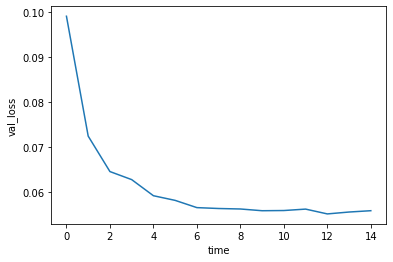

In [36]:
plt.plot(recordFreeze.history['val_loss'])
plt.xlabel('time')
plt.ylabel('val_loss')
plt.show()

In [ ]:
predict_on_xception(12500, 299, 299, test_data_dir, model, "xception-best_weight_freeze.h5", "pred-xception-freeze.csv")

将pred-xception-freeze.csv提交到Kaggle中进行评分，Xception-freeze本次的得分为:0.06179。从这一个阶段的结果可以看出训练全连接层对于结果的改变是较为显著的，而且如果仅仅是训练

具体的得分情况可以在报告文档中进行查看。

我们可以看到，如果仅仅只是对全连接层进行训练的话，神经网络内部参数不进行更多的改变的话是比较难以适应或者说贴合识别猫和狗的特定需求的。因此在这个基础上我们需要开放更多层级的权限让训练集更加充分地调整神经网络的参数。

由于在之前的层数结构中我们可以看到我们添加了Dropout层和全连接层的Xception模型中在最后几段中分为87, 97, 107, 117, 127几个节段。为了使得能够训练的参数数目足够多，同时兼顾训练的时间成本，我们在这里仅仅选择了97以及107以上的部分进行后续的参数调整和训练。

In [37]:
for layer in model.layers:
    layer.trainable = False
    
for layer in model.layers[97:]:
    layer.trainable = True
    
model.load_weights('xception-best_weight_freeze.h5')
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
#训练模型并保存在验证集上损失函数最小的权重
filepath="xception-97.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

record97 = model.fit_generator(
        train_generator,
        steps_per_epoch=625,
        epochs=15,
        validation_data=valid_generator,
        validation_steps=150,
        callbacks = callbacks_list)

Epoch 1/15
625/625 [==============================] - 378s 605ms/step - loss: 0.0969 - acc: 0.9677 - val_loss: 0.0290 - val_acc: 0.9936
Epoch 2/15
625/625 [==============================] - 388s 621ms/step - loss: 0.0612 - acc: 0.9808 - val_loss: 0.0273 - val_acc: 0.9938
Epoch 3/15
625/625 [==============================] - 387s 619ms/step - loss: 0.0507 - acc: 0.9849 - val_loss: 0.0263 - val_acc: 0.9940
Epoch 4/15
625/625 [==============================] - 427s 684ms/step - loss: 0.0375 - acc: 0.9880 - val_loss: 0.0212 - val_acc: 0.9944
Epoch 5/15
625/625 [==============================] - 432s 691ms/step - loss: 0.0385 - acc: 0.9886 - val_loss: 0.0233 - val_acc: 0.9934
Epoch 6/15
625/625 [==============================] - 412s 659ms/step - loss: 0.0310 - acc: 0.9906 - val_loss: 0.0200 - val_acc: 0.9940
Epoch 7/15
625/625 [==============================] - 394s 630ms/step - loss: 0.0296 - acc: 0.9908 - val_loss: 0.0198 - val_acc: 0.9942
Epoch 8/15
625/625 [============================

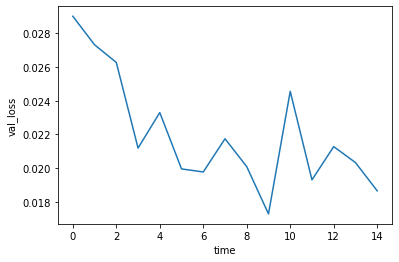

In [39]:
plt.plot(record97.history['val_loss'])
plt.xlabel('time')
plt.ylabel('val_loss')
plt.show()

In [40]:
predict_on_xception(12500, 299, 299, test_data_dir, model, "xception-97.h5", "pred-xception-result97.csv")

100%|██████████| 12500/12500 [00:52<00:00, 237.36it/s]


12500/12500 [==============================] - 148s 12ms/step


100%|██████████| 12500/12500 [00:00<00:00, 197905.02it/s]


将pred-xception-result97.csv提交到Kaggle中进行评分，Xception-97本次的得分为:0.03709。在Kaggle的排名中已经能够进入前10名了，因此这是一个较为成功的模型，而这也说明对Xception中不同层的权重进行针对特定目标的调整是有很显著的作用的。

具体的得分情况可以在报告文档中进行查看。

在完成了97层之后的调整之后，我们可以尝试继续探索一下不同程度地对权重进行调整可能造成的影响。因为Xception中的权重是由专业人士进行尝试与确定的，虽然对于不同的任务模型的效果可能会有一定的出入，但是其效用是在一定程度上经过更加严格的检验的。我们通过重新调整权重则从某种程度上是对这个模型功能完整性的一种破坏。如何在这种破坏和功能特化中找到效率的平衡点，这是通过微调提升模型能力需要考虑的一点。而由于时间有限，在这一个项目中我对107层之后的样本进行了参数调节层数优化的进一步探索。

In [41]:
for layer in model.layers:
    layer.trainable = False
    
for layer in model.layers[107:]:
    layer.trainable = True
    
model.load_weights('xception-best_weight_freeze.h5')
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
filepath="xception-107.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

record107 = model.fit_generator(
        train_generator,
        steps_per_epoch=625,
        epochs=15,
        validation_data=valid_generator,
        validation_steps=150,
        callbacks = callbacks_list)

Epoch 1/15
625/625 [==============================] - 355s 568ms/step - loss: 0.0988 - acc: 0.9669 - val_loss: 0.0278 - val_acc: 0.9932
Epoch 2/15
625/625 [==============================] - 349s 559ms/step - loss: 0.0644 - acc: 0.9792 - val_loss: 0.0257 - val_acc: 0.9928
Epoch 3/15
625/625 [==============================] - 344s 550ms/step - loss: 0.0541 - acc: 0.9838 - val_loss: 0.0305 - val_acc: 0.9912
Epoch 4/15
625/625 [==============================] - 354s 566ms/step - loss: 0.0474 - acc: 0.9849 - val_loss: 0.0230 - val_acc: 0.9940
Epoch 5/15
625/625 [==============================] - 388s 621ms/step - loss: 0.0421 - acc: 0.9863 - val_loss: 0.0181 - val_acc: 0.9954
Epoch 6/15
625/625 [==============================] - 389s 623ms/step - loss: 0.0354 - acc: 0.9886 - val_loss: 0.0193 - val_acc: 0.9946
Epoch 7/15
625/625 [==============================] - 362s 579ms/step - loss: 0.0321 - acc: 0.9903 - val_loss: 0.0197 - val_acc: 0.9944
Epoch 8/15
625/625 [============================

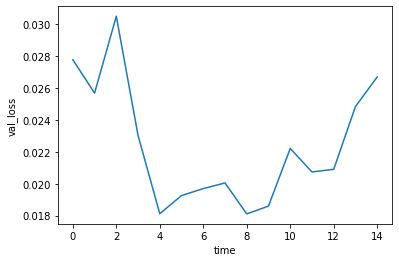

In [44]:
plt.plot(record107.history['val_loss'])
plt.xlabel('time')
plt.ylabel('val_loss')
plt.show()

In [45]:
predict_on_xception(12500, 299, 299, test_data_dir, model, "xception-107.h5", "pred-xception-fine_result107.csv")

100%|██████████| 12500/12500 [00:55<00:00, 225.51it/s]


12500/12500 [==============================] - 158s 13ms/step


100%|██████████| 12500/12500 [00:00<00:00, 191599.82it/s]


将pred-xception-result107.csv提交到Kaggle中进行评分，Xception-107本次的得分为:0.04183。结果并没有比之前的Xception-97更优而且训练效果并不理想，因此可以认为在目前探索的两个模型中Xception-97是我们最终使用的模型。

具体的得分情况可以在报告文档中进行查看。


## 结果
经过了Dropout的调整以及对Xception中不同层的参数进行训练和调整之后，得到的最佳模型是Xception-97，它在Kaggle中的得分是0.03709，排名为第7名。因此，我们可以认为这个模型的结果已经初步符合我们对于项目结果的预期。